In [46]:
import numpy as np
import matplotlib.pyplot as plt

def show_convergence(model):
    
    plt.plot(np.array(model.HISTORY["q"]).T[0], c = "red")
    plt.plot(np.array(model.HISTORY["q"]).T[1], c = "blue")
    plt.plot(np.array(model.HISTORY["q"]).T[2], c = "green")
    plt.plot(np.array(model.HISTORY["q"]).T[3], c = "black")
    plt.plot(np.array(model.HISTORY["q"]).T[4], c = "yellow")

In [47]:
class Environment:
    def __init__(self, rewards = [-1, 2, 1, 5, 3], deviation = 0.5):
        self.rewards = rewards
        self.deviation = deviation

    def get_reward(self, action_index):
        return self.rewards[action_index] + np.random.randn() * self.deviation

In [48]:
env = Environment()
env.get_reward(2)

0.9575647044841168

## Vanilla Bandit

In [49]:
class VanillaBandit:

    def __init__(self, env, arms = 5):

        self.arms = arms
        self.q_values = np.zeros(self.arms)
        self.action_attempts = np.zeros(self.arms)

        self.env = env

        self.HISTORY = {"q" : [self.q_values.copy()], "action_attempts" : [self.action_attempts.copy()]} 

    def learn(self, horizon = 10000, e = 1):

        for _ in range(horizon):

            if np.random.rand() < e:
                action = np.random.randint(self.arms)
            else:
                action = np.argmax(self.q_values)

            reward = env.get_reward(action)

            self.action_attempts[action] += 1
            self.q_values[action] += (reward - self.q_values[action])/self.action_attempts[action]
        

            self.HISTORY["q"] += [self.q_values.copy()]
            self.HISTORY["action_attempts"] += [self.action_attempts.copy()]

            #decay e
            e -= 1/(horizon * 0.75)

In [67]:
vanilla = VanillaBandit(env)
vanilla.learn(horizon=100)

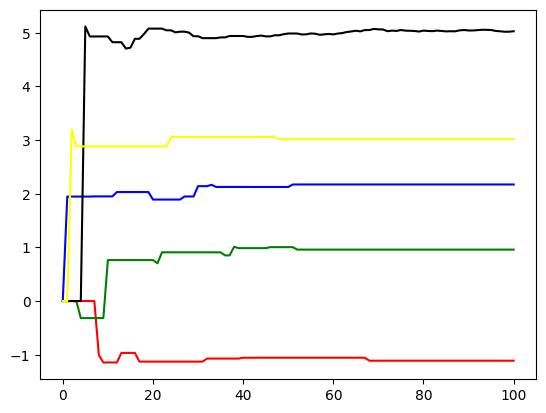

In [68]:
show_convergence(vanilla)

## Explore-Then-Commit Bandit

### Static

In [52]:
class StaticETC:

    def __init__(self, env, arms = 5, M=10):

        self.arms = arms
        self.q_values = np.zeros(self.arms)
        self.action_attempts = np.zeros(self.arms)

        # additions to vanilla bandit
        self.M = M

        self.env = env
        self.HISTORY = {"q" : [self.q_values.copy()], "action_attempts" : [self.action_attempts.copy()]} 

    def learn(self, horizon = 10000, e = 1):

        for _ in range(horizon):

            # policy change
            if _ < self.M * self.arms:
                action = _ % self.arms
            else:
                action = np.argmax(self.q_values)

            reward = env.get_reward(action)

            self.action_attempts[action] += 1
            self.q_values[action] += (reward - self.q_values[action])/self.action_attempts[action]
            

            self.HISTORY["q"] += [self.q_values.copy()]
            self.HISTORY["action_attempts"] += [self.action_attempts.copy()]

            #decay e
            e -= 1/(horizon * 0.75)


In [53]:
s_etc = StaticETC(env)
s_etc.learn(100)

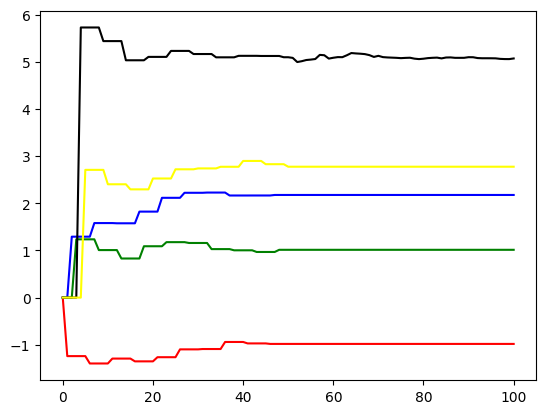

In [54]:
show_convergence(s_etc)

### Data-dependant

In [55]:
class DataETC:

    def __init__(self, env, arms = 5, M=10):

        self.arms = arms
        self.q_values = np.zeros(self.arms)
        self.action_attempts = np.zeros(self.arms)

        # additions to vanilla bandit
        self.M = M

        self.exploit_flag = 0

        self.env = env
        self.HISTORY = {"q" : [self.q_values.copy()], "action_attempts" : [self.action_attempts.copy()]} 

    def learn(self, horizon = 10000, e = 1):

        for _ in range(horizon):

            if not self.exploit_flag and not self.end_explore():
                action = _ % self.arms
            else:
                action = np.argmax(self.q_values)

            reward = env.get_reward(action)

            self.action_attempts[action] += 1
            self.q_values[action] += (reward - self.q_values[action])/self.action_attempts[action]
            

            self.HISTORY["q"] += [self.q_values.copy()]
            self.HISTORY["action_attempts"] += [self.action_attempts.copy()]

            e -= 1/(horizon * 0.75)

    def end_explore(self):
        MAX_2, MAX = np.sort(self.q_values)[-2:]

        if (MAX - MAX_2) >= 2:
            self.exploit_flag = 1
            return True
        return False

In [56]:
d_etc = DataETC(env)
d_etc.learn(100)

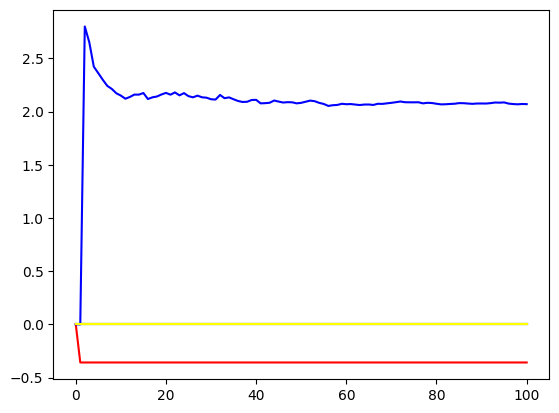

In [57]:
show_convergence(d_etc)

## Upper-Confidence Bound

In [58]:
class UCBBandit:

    def __init__(self, env, arms = 5):

        self.arms = arms
        self.q_values = np.zeros(self.arms)
        self.action_attempts = np.zeros(self.arms)

        self.env = env

        self.HISTORY = {"q" : [self.q_values.copy()], "action_attempts" : [self.action_attempts.copy()]} 

    def learn(self, horizon = 10000, e = 1):

        for _ in range(horizon):

            # policy change
            ucb = self.estimate_UCB()
            action = np.argmax(ucb)
            
            reward = env.get_reward(action)

            self.action_attempts[action] += 1
            self.q_values[action] += (reward - self.q_values[action])/self.action_attempts[action]
        

            self.HISTORY["q"] += [self.q_values.copy()]
            self.HISTORY["action_attempts"] += [self.action_attempts.copy()]

            #decay e
            e -= 1/(horizon * 0.75)

    def estimate_UCB(self, d=0.5):
        ucb = np.full(self.arms, 9999)

        for _ in range(self.arms):
            
            if self.action_attempts[_]:
                ucb[_] = self.q_values[_] + np.sqrt((2*np.log(1/d))/self.action_attempts[_])
        return ucb

In [59]:
ucb = UCBBandit(env)
ucb.learn(100)

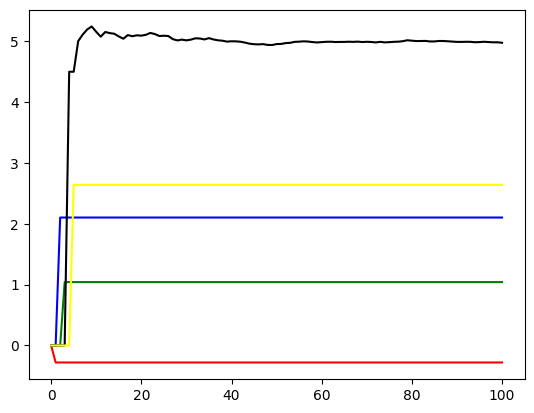

In [60]:
show_convergence(ucb)